# Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import re
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator

from tqdm import tqdm

In [2]:
def drop_rows_with_nan(df, how='any', subset=None):
    """
    Removes rows containing NaN values from a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame to process.
        how: 'any' to drop rows containing *any* NaN values, 'all' to drop only rows where *all* values are NaN.
        subset: An optional list of column names to consider. If None, all columns are checked.

    Returns:
        pandas.DataFrame: A new DataFrame with the NaN-containing rows removed.
                          The original DataFrame is not modified.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()
    df_cleaned = df_cleaned.dropna(axis=0, how=how, subset=subset)
    return df_cleaned

# Working on...

In [3]:
# Specify the directory path
dir_path = "../files/data/RAW"

# Get folder names
master_folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(master_folders)

# Specify the directory path
dir_path = "../files/data/RAW/{}".format(master_folders[4])

# # Get folder names
# folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

# Get folder names that start with "DOUBLE_"
folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f)) and f.startswith('DOUBLE_')]

print(folders)

['FA7000-15-D-0006-19FA202', 'BH_SINGLE', 'FA700021D0002-23F0143', 'FA7000-15-D-0006-0016', 'FA7000-15-D-0006-9011', 'FA700021D0002-22F0214', 'TWIN', 'FA7000-15-D-0006-20F0212']
['DOUBLE_DATABASES_Rt1d0_8Mar2019', 'DOUBLE_DATABASES_Rt2d0_3Apr2019', 'DOUBLE_DATABASES_Rt1d5_8May2019', 'DOUBLE_DATABASES_Rt0d5_17Sep2019', 'DOUBLE_DATABASES_Rt2_3Apr2019', 'DOUBLE_DATABASES_Rt5d0_17Sep2019', 'DOUBLE_DATABASES_Rt3d0_8May2019', 'DOUBLE_DATABASES_8Mar2019']


# .DAT to .csv

In [ ]:
def process_file(file_info):
    input_file_path, output_file_path = file_info
    
    rows = []
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        W_R, a_c, a_t, r_t, b_t = None, None, None, None, None
        c_index = 0

        for i, line in enumerate(lines):
            values = line.strip().split()
            if not values:
                continue
            
            if values[0] == "Geometry:":
                crack = False
                # Extract the coefficient multiplying R (which is W/R)
                wr_match = re.search(r"W=h=\s*([\d.]+)\*R", line)
                if wr_match:
                    W_R = float(wr_match.group(1))

                # Extract b/t value
                bt_match = re.search(r"with\s*b/t=([\d.]+)", line)
                if bt_match:
                    b_t = float(bt_match.group(1))

            if values[0] == "Scenario:":
                crack = False
                c_index = values[1]

            elif values[0] == "ndom" and (values[1] == "a1/c1" or values[1] == "a2/c2"):
                crack = False
                next_values = lines[i + 1].strip().split()
                a_c, a_t, r_t = map(float, next_values[1:4])

            elif values[0] == "crack":
                crack = True

            elif values[0].isdigit() and crack:
                row = [c_index] + list(map(float, values[0])) + [W_R, a_c, a_t, r_t, b_t] + list(map(float, values[5:9]))
                rows.append(row)

    df = pd.DataFrame(rows, columns=['c_index', 'crack', 'W/R', 'a/c', 'a/t', 'r/t', 'b/t', 'phi', 'K-T', 'K-B', 'K-P'])
    df.to_csv(output_file_path, index=False)

master_folder = master_folders[4]
tasks = []

for folder in folders:
    dir_path = os.path.join("../files/data/RAW", master_folder, folder)
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

    for file_name in files:
        input_file_path = os.path.join(dir_path, file_name)
        output_file_path = os.path.join(dir_path, f"{file_name[:-6]}.csv")
        tasks.append((input_file_path, output_file_path))


# for i in tqdm(range(len(tasks))):
#     process_file(tasks[i])

with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_file, tasks), total=len(tasks), desc="Processing Files"))

Processing Files:   0%|          | 0/155 [00:00<?, ?it/s]

In [46]:
df = pd.read_csv("../files/data/TWIN/BH/CASE24-TWIN-Rt-3dot0.csv")
df = drop_rows_with_nan(df)
df

,c_index,crack,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,1,1.0,0.1,0.1,3.0,0.00000,0.6244,0.5123,12.83
1,1,1.0,0.1,0.1,3.0,0.00006,0.6484,0.5320,13.33
2,1,1.0,0.1,0.1,3.0,0.00012,0.6662,0.5466,13.69
3,1,1.0,0.1,0.1,3.0,0.00018,0.6787,0.5569,13.95
4,1,1.0,0.1,0.1,3.0,0.00024,0.6872,0.5638,14.12
...,...,...,...,...,...,...,...,...,...
13047931,36864,2.0,10.0,10.0,3.0,0.10016,5.1080,-3.0690,116.00
13047932,36864,2.0,10.0,10.0,3.0,0.10016,5.0370,-3.0270,114.40
13047933,36864,2.0,10.0,10.0,3.0,0.10017,4.9360,-2.9670,112.10
13047934,36864,2.0,10.0,10.0,3.0,0.10017,4.7990,-2.8850,109.00


In [47]:
unique_index = df['c_index'].unique()
unique_index

array([    1,     2,     3, ..., 36862, 36863, 36864], shape=(36864,))

In [48]:
column_to_check = "crack" # Or replace with the actual column name string, e.g., 'crack_type'

# --- Optimized Logic ---

# 1. Group by 'c_index' and count unique values in the target column for each group
unique_counts = df.groupby('c_index')[column_to_check].nunique()

# 2. Filter the result to find indices where the unique count is NOT 2
corrupt_indices = unique_counts[unique_counts != 2].index

# 3. Convert the resulting index object to a list (if you need a list)
corrupt_list = corrupt_indices.tolist()

# Now corrupt_list contains the same values as your original 'corrupt' list
print(corrupt_list)

[]


In [49]:
df = df[~df['c_index'].isin(corrupt_list)]
df

,c_index,crack,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,1,1.0,0.1,0.1,3.0,0.00000,0.6244,0.5123,12.83
1,1,1.0,0.1,0.1,3.0,0.00006,0.6484,0.5320,13.33
2,1,1.0,0.1,0.1,3.0,0.00012,0.6662,0.5466,13.69
3,1,1.0,0.1,0.1,3.0,0.00018,0.6787,0.5569,13.95
4,1,1.0,0.1,0.1,3.0,0.00024,0.6872,0.5638,14.12
...,...,...,...,...,...,...,...,...,...
13047931,36864,2.0,10.0,10.0,3.0,0.10016,5.1080,-3.0690,116.00
13047932,36864,2.0,10.0,10.0,3.0,0.10016,5.0370,-3.0270,114.40
13047933,36864,2.0,10.0,10.0,3.0,0.10017,4.9360,-2.9670,112.10
13047934,36864,2.0,10.0,10.0,3.0,0.10017,4.7990,-2.8850,109.00


In [50]:
unique_index = df['c_index'].unique()
unique_index

array([    1,     2,     3, ..., 36862, 36863, 36864], shape=(36864,))

In [51]:
d_final = np.zeros((len(unique_index)*128, 14))

ui = 0
for unq_index in tqdm(unique_index):
    data = np.zeros((128, 14))
    filtered_df = df[df["c_index"] == unq_index]

    cracks = np.unique(filtered_df.to_numpy()[:,1])

    data[:,0] = unq_index
    for crack in cracks:
        filtered_df_ = filtered_df[filtered_df["crack"] == crack]

        filtered_d_ = filtered_df_.to_numpy()

        a_c = np.unique(filtered_d_[:,2])
        a_t = np.unique(filtered_d_[:,3])
        r_t = np.unique(filtered_d_[:,4])

        assert len(a_c) == 1, a_c
        assert len(a_t) == 1, a_t
        assert len(r_t) == 1, r_t

        phi_vals = filtered_d_[:,-4]
        phi_min = phi_vals.min() + 0.035
        phi_max = phi_vals.max() - 0.035
        # Filter indices where phi values lie within [phi_min, phi_max]
        filtered_indices = (phi_vals >= phi_min) & (phi_vals <= phi_max)
        phi_vals = phi_vals[filtered_indices]
        assert len(phi_vals) > 16, len(phi_vals)
        phi_idxes = np.argsort(phi_vals)
        
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]

        phi_regular_128 = np.linspace(phi_min + 0.005, phi_max - 0.005, 130)

        # Tension
        K_vals = filtered_d_[:,-3]
        K_vals = K_vals[filtered_indices]
        
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        KT_regular_128 = interp_func(phi_regular_128)

        # Bending
        K_vals = filtered_d_[:,-2]
        K_vals = K_vals[filtered_indices]
        
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        KB_regular_128 = interp_func(phi_regular_128)

        # Pin
        K_vals = filtered_d_[:,-1]
        K_vals = K_vals[filtered_indices]
        
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
        KP_regular_128 = interp_func(phi_regular_128)

        if crack == 1:
            data[:,1] = a_c[0]
            data[:,2] = a_t[0]
            data[:,5] = r_t[0]
            data[:,6] = phi_regular_128[1:-1]
            data[:,8] = KT_regular_128[1:-1]
            data[:,10] = KB_regular_128[1:-1]
            data[:,12] = KP_regular_128[1:-1]
        
        elif crack == 2:
            data[:,3] = a_c[0]
            data[:,4] = a_t[0]
            data[:,5] = r_t[0]
            data[:,7] = phi_regular_128[1:-1]
            data[:,9] = KT_regular_128[1:-1]
            data[:,11] = KB_regular_128[1:-1]
            data[:,13] = KP_regular_128[1:-1]
        
        else:
            print("Something is wrong with crack")

    d_final[ui*128:ui*128+128] = data
    ui += 1

100%|██████████| 36864/36864 [06:06<00:00, 100.49it/s]


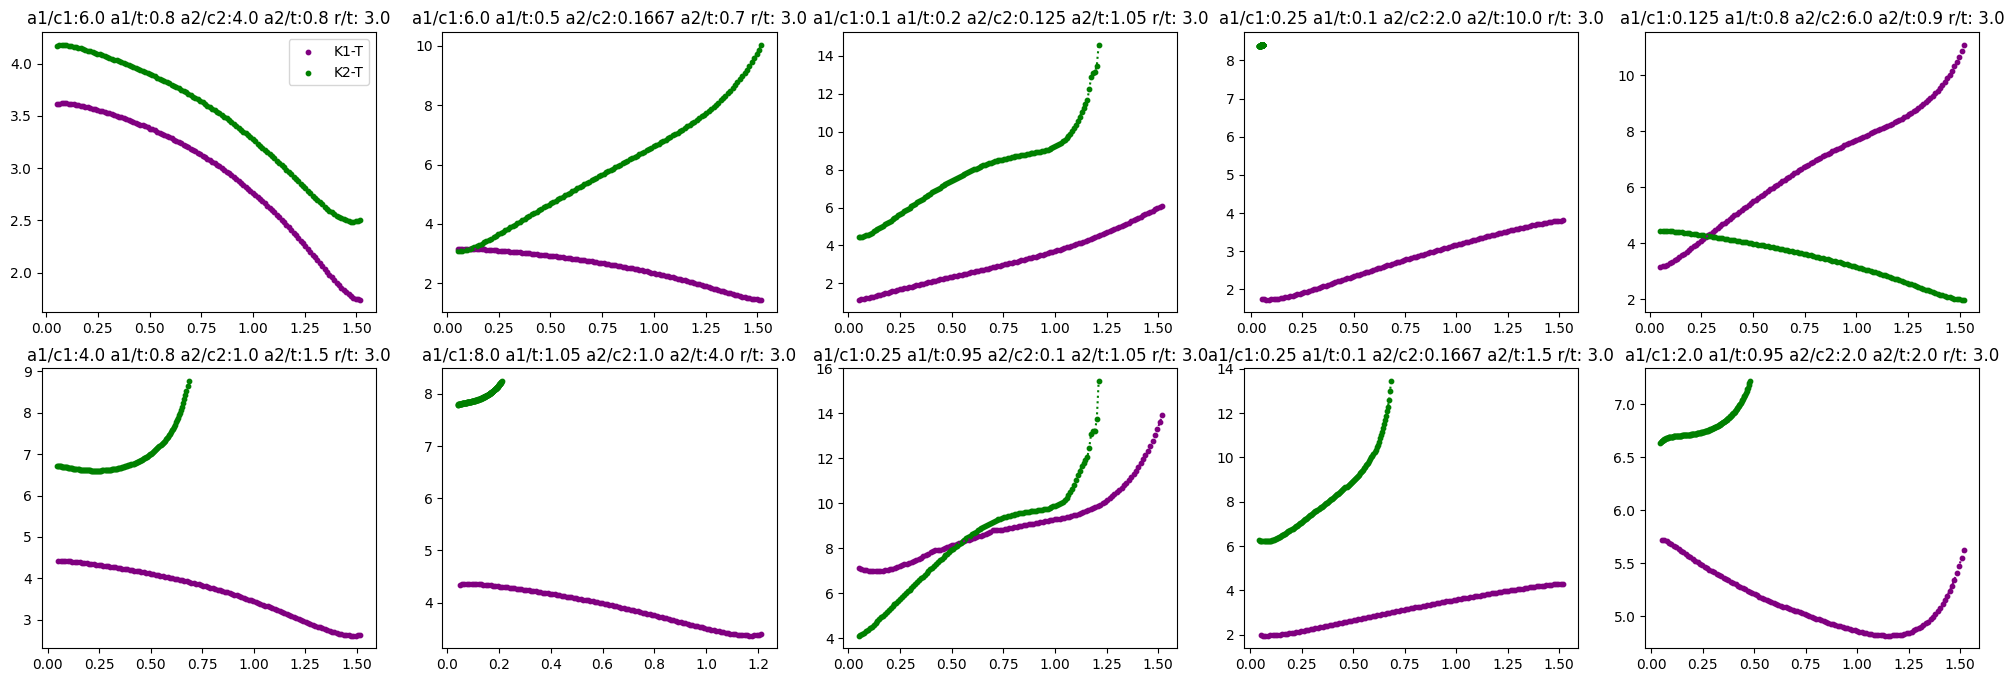

In [52]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(25,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(unique_index))
        idx = unique_index[idx]
        data = d_final[idx*128:idx*128+128]
        a1_c1 = np.unique(data[:,1])
        a1_t = np.unique(data[:,2])
        a2_c2 = np.unique(data[:,3])
        a2_t = np.unique(data[:,4])
        r_t = np.unique(data[:,5])

        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1

        axs[i,j].scatter(data[:,6], data[:,8], label="K1-T", color='purple', s=10)
        axs[i,j].plot(data[:,6], data[:,8], color='purple', linestyle=":")

        axs[i,j].scatter(data[:,7], data[:,9], label="K2-T", color='green', s=10)
        axs[i,j].plot(data[:,7], data[:,9], color='green', linestyle=":")

        axs[i,j].set_title("a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t: {}".format(a1_c1[0],
                                                                              a1_t[0],
                                                                              a2_c2[0],
                                                                              a2_t[0],
                                                                              r_t[0]))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [53]:
nan_mask = np.isnan(d_final)
row_has_nan = np.any(nan_mask, axis=1)
row_indices_with_nan = np.where(row_has_nan)[0]
row_indices_with_nan

array([], dtype=int64)

In [54]:
df = pd.DataFrame(d_final, columns=["c_index", "a1/c1", "a1/t", "a2/c2", "a2/t", 
                                    "r/t", "phi_1", "phi_2", "K1-T", "K2-T", 
                                    "K1-B", "K2-B", "K1-P", "K2-P"])

df.to_csv("../files/data/TWIN/BH/CASE24-TWIN-Rt-3dot0-CLEANED.csv")

In [55]:
df

,c_index,a1/c1,a1/t,a2/c2,a2/t,r/t,phi_1,phi_2,K1-T,K2-T,K1-B,K2-B,K1-P,K2-P
0,1.0,0.1,0.1,0.1,0.1,3.0,0.051557,0.051557,0.732962,0.732962,0.598604,0.598604,15.068041,15.068041
1,1.0,0.1,0.1,0.1,0.1,3.0,0.063113,0.063113,0.744571,0.744571,0.607406,0.607406,15.311323,15.311323
2,1.0,0.1,0.1,0.1,0.1,3.0,0.074670,0.074670,0.759112,0.759112,0.618499,0.618499,15.614303,15.614303
3,1.0,0.1,0.1,0.1,0.1,3.0,0.086226,0.086226,0.775955,0.775955,0.631402,0.631402,15.965639,15.965639
4,1.0,0.1,0.1,0.1,0.1,3.0,0.097783,0.097783,0.794622,0.794622,0.645716,0.645716,16.350449,16.350449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718587,36864.0,10.0,10.0,10.0,10.0,3.0,0.059388,0.059388,7.202645,7.202645,-0.710303,-0.710303,165.787355,165.787355
4718588,36864.0,10.0,10.0,10.0,10.0,3.0,0.059545,0.059545,7.202479,7.202479,-0.722333,-0.722333,165.777152,165.777152
4718589,36864.0,10.0,10.0,10.0,10.0,3.0,0.059701,0.059701,7.202303,7.202303,-0.734370,-0.734370,165.765207,165.765207
4718590,36864.0,10.0,10.0,10.0,10.0,3.0,0.059857,0.059857,7.202117,7.202117,-0.746411,-0.746411,165.752322,165.752322
